# Demo


The purpose of this notebook is to create a minimum working example of seaglider data in OG1 format. The test case is to convert sg015 data from the Labrador Sea in September 2004.

- OG1 format is a newly agreed format (since June 2024) for glider data sets from various platforms (e.g., Seaglider, Slocum, Seaexplorer).  It lives on github here: (https://github.com/OceanGlidersCommunity/OG-format-user-manual).
- OG1 manual: https://oceangliderscommunity.github.io/OG-format-user-manual/OG_Format.html


In [1]:
import sys
import importlib
sys.path.append('/Users/eddifying/Cloudfree/gitlab-cloudfree/seagliderOG1')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from seagliderOG1 import fetchers
from seagliderOG1 import tools
from seagliderOG1 import plotters
from seagliderOG1 import vocabularies
import xarray as xr
import os

## Load Seaglider data in native format

This has three ways to load a glider dataset.

Load an example dataset using `seagliderOG1.fetchers.load_sample_dataset`

Alternatively, use your own with e.g. `ds = xr.open_dataset('/path/to/yourfile.nc')`

### Load a sample dataset

These data are hosted (currently) on dropbox.

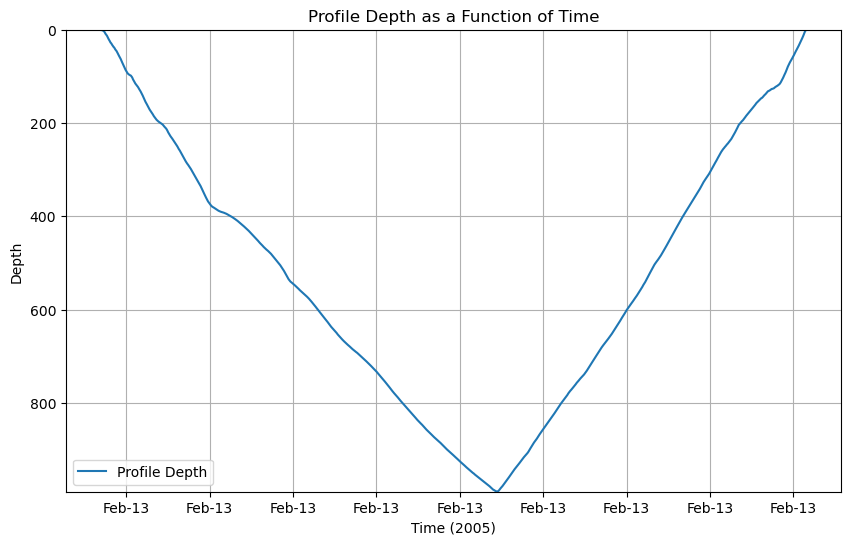

In [3]:
# List of available datasets
file_list = ['p0150500_20050213.nc', 'p0150501_20050213.nc', 'p0150502_20050214.nc', 'p0150503_20050214.nc', 'p0150504_20050215.nc'];

# Loads one dataset (p0150500_20050213.nc)
ds = fetchers.load_sample_dataset()

# Check the results
plotters.plot_profile_depth(ds)
#plotters.show_variables_xarray(ds)

### Load dataset from local machine

- For local data in the directory `input_dir`
- Creates a plot of ctd_depth against ctd_time.


In [4]:
# Specify the input directory on your local machine
input_dir = "/Users/eddifying/Dropbox/data/sg015-ncei-download"

# Load and concatenate all datasets in the input directory
# Optionally, specify the range of profiles to load (start_profile, end_profile)
ds_all = fetchers.load_dataset(input_dir, start_profile=500, end_profile=500)

# Simple plot of depth against time
#plotters.plot_profile_depth(ds_all)
#plotters.show_contents(ds_all)



/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


### Load data from the NCEI server

- Data from the sg015 mission in the Labrador Sea (https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0111844), dataset identifier gov.noaa.nodc:0111844.


/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


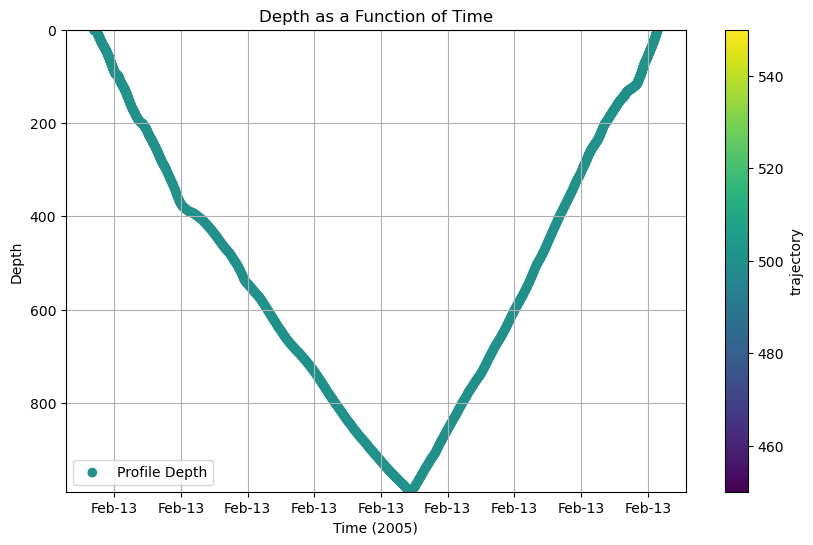

In [5]:
# Specify the server where data are located
server = "https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/015/20040924/"

# This was necessary to get an initial file list
# mylist = fetchers.list_files_in_https_server(server)
# fetchers.create_pooch_registry_from_directory("/Users/eddifying/Dropbox/data/sg015-ncei-download/")

# Load and concatenate all datasets from the server, optionally specifying the range of profiles to load
ds_all = fetchers.load_dataset(server, start_profile=500, end_profile=500)

#plotters.show_contents(ds_all)
# Simple plot of depth against time
plotters.plot_depth_colored(ds_all, color_by='trajectory')#


In [6]:
ds_all

<xarray.Dataset>
Dimensions:                       (sg_data_point: 1180)
Coordinates:
    trajectory                    (sg_data_point) float64 500.0 500.0 ... 500.0
    longitude                     (sg_data_point) float64 -55.35 ... -55.38
    latitude                      (sg_data_point) float64 58.3 58.3 ... 58.33
    ctd_time                      (sg_data_point) datetime64[ns] 2005-02-13T1...
    ctd_depth                     (sg_data_point) float64 0.7258 ... 0.7871
Dimensions without coordinates: sg_data_point
Data variables: (12/214)
    surface_curr_north            (sg_data_point) float64 8.515 8.515 ... 8.515
    surface_curr_east             (sg_data_point) float64 9.955 9.955 ... 9.955
    start_of_climb_time           (sg_data_point) timedelta64[ns] 04:45:19 .....
    sg_cal_volmax                 (sg_data_point) float64 5.15e+04 ... 5.15e+04
    sg_cal_vbd_min_cnts           (sg_data_point) int32 177 177 177 ... 177 177
    sg_cal_vbd_max_cnts           (sg_data_point) int32 3527 3527 ... 3527 3527
    ...                            ...
    GPS2_qc                       (sg_data_point) |S1 b'1' b'1' ... b'1' b'1'
    GPS1_qc                       (sg_data_point) |S1 b'1' b'1' ... b'1' b'1'
    CTD_qc                        (sg_data_point) |S1 b'1' b'1' ... b'1' b'1'
    gps_lat                       (sg_data_point) float64 58.3 nan ... nan 58.33
    gps_lon                       (sg_data_point) float64 -55.35 nan ... -55.38
    gps_time                      (sg_data_point) float64 1.108e+18 ... 1.108...
Attributes: (12/58)
    quality_control_version:         1.1
    base_station_micro_version:      3705
    time_coverage_resolution:        PT1S
    geospatial_vertical_max:         989.6984588132262
    sea_name:                        Labrador Sea
    mission:                         1
    ...                              ...
    disclaimer:                      Data has not been reviewed and is provid...
    geospatial_vertical_positive:    no
    date_created:                    2013-08-01T05:08:54Z
    geospatial_vertical_units:       meter
    dive_number:                     500
    history:                         Processing start:\n05:52:52 01 Aug 2013 ...

## Reformat into OG1

### Check the attributes in the basestation file


In [ ]:
file_list = ['p0150500_20050213.nc', 'p0150501_20050213.nc', 'p0150502_20050214.nc', 'p0150503_20050214.nc', 'p0150504_20050215.nc'];
input_dir = "/Users/eddifying/Dropbox/data/sg015-ncei-download" 

ds = xr.open_dataset(os.path.join(input_dir, file_list[0])) 
# Show the result
#plotters.show_contents(ds,'vars')


information is based on xarray Dataset


,dims,units,comment,standard_name
name,,,,
gc_data_pts,gc_event,1,,
gc_depth,gc_event,meters,,
gc_end_secs,gc_event,,End of GC time in GMT epoch format,
gc_gcphase,gc_event,,,
gc_ob_vertv,gc_event,cm/s,,
gc_pitch_ctl,gc_event,cm,,
gc_pitch_secs,gc_event,,Elapsed seconds since start of this pitch change,
gc_roll_secs,gc_event,,Elapsed seconds since start of this roll change,
gc_st_secs,gc_event,,Start of GC time in GMT epoch format,


# Manual check of changes

In [ ]:
# Check what we're going to delete in concatenating datasets with fetchers.load_dataset()

# Load everything from the raw basestation file
def load_netcdf_file(source, profile_number=500):

    if source.startswith("http://") or source.startswith("https://"):
        # Create a Pooch object to manage the remote files
        data_source_online = pooch.create(
            path=pooch.os_cache("seagliderOG1_online"),
            base_url=source,
            registry=None,
        )
    filenames = []
    datasets = []

    for file in file_list:
        if file.endswith(".nc"):
            file_profile_num = int(file.split("_")[0][4:])
            if file_profile_num == profile_number:
                    filenames.append(file)            

    for file in filenames:
        if source.startswith("http://") or source.startswith("https://"):
            ds = fetchers.load_sample_dataset(file)
        else:
            ds = xr.open_dataset(os.path.join(source, file))

    return ds

# Load one dataset
file_list = ['p0150501_20050213.nc']
filenames = input_dir + "/" + file_list[0]
ds = xr.open_dataset(os.path.join(input_dir, file_list[0  ]))

# Check what dimensions they correspond to (everything without dimension sg_data_point is dropped)
new_ds = fetchers.extract_non_sg_data_point_vars(ds)

# Show the keys (dimension names)
#print(new_ds.keys())

# What variables are these?
plotters.show_variables_by_dimension(ds, dimension_name='gc_info')

if 0:
    # Some variables (like dive_number stored in 'trajectory' should be repeated for each sg_data_point)
    # Extract the value of the variable with dimensions of trajectory
    trajectory_var = ds['trajectory'].values

    # Expand its length to match sg_data_point
    expanded_trajectory_var = np.repeat(trajectory_var, ds.dims['sg_data_point'])

    # Insert it as a new variable in the ds dataset with dimension sg_data_point
    ds['trajectory_new'] = (['sg_data_point'], expanded_trajectory_var)

# Other variables, like log_gps_lat and log_gps_lon should only appear at the nearest point in time
# This is done with the function fetchers.add_gps_coordinates()

# Example usage
#plotters.plot_depth_colored(ds, color_by='trajectory_new')

#plotters.show_variables_by_dimension(ds, dimension_name='sg_data_point')
#plotters.show_variables_by_dimension(ds, dimension_name='gps_info')
if 0:
    print(ds.log_gps_time)

    ds = ds_all

    # Append log_gps_time values to TIME
    time_length = ds['ctd_time'].size
    log_gps_time_length = ds['log_gps_time'].size
    new_time_length = time_length + log_gps_time_length

    new_time = np.full(new_time_length, np.nan)
    new_time[:time_length] = ds['ctd_time'].values
    new_time[time_length:] = ds['log_gps_time'].values

    ds['TIME'] = (['sg_data_point'], new_time)

    # Convert log_gps_time from seconds since 1970-01-01T00:00:00Z to datetime64 format
    if 0:
        ds['log_gps_time'] = xr.DataArray(
            np.datetime64('1970-01-01T00:00:00Z') + ds['log_gps_time'].values.astype('timedelta64[s]'),
            dims=ds['log_gps_time'].dims,
            attrs=ds['log_gps_time'].attrs
        )

        # Verify the conversion
    print(ds['log_gps_time'].values)

#plotters.show_contents(new_ds)


In [ ]:
# Apply the function to ds
ds = fetchers.add_gps_coordinates(ds)

#plotters.plot_ctd_depth_vs_time(ds_all)
# Convert non-NaN gps_time values from seconds since 1970-01-01 to datetime64 format
non_nan_gps_time = ds['gps_time'].dropna(dim='sg_data_point')
converted_gps_time = np.datetime64('1970-01-01T00:00:00Z') + non_nan_gps_time.values.astype('timedelta64[s]')

# Print the converted values
print(converted_gps_time)


# Now run the whole thing

### Load data

In [ ]:
# Specify the input directory on your local machine
input_dir = "/Users/eddifying/Dropbox/data/sg015-ncei-download"

# Load and concatenate all datasets in the input directory
# Optionally, specify the range of profiles to load (start_profile, end_profile)
ds_all = fetchers.load_dataset(input_dir, start_profile=500, end_profile=501)

### Assign new attributes

Some of the attributes in the basestation netcdf file can be translated fairly easily into the OG1 format.  This is done in `tools.modify_attributes`.  At present, the "extra" attributes are retained at the bottom of the list.


In [ ]:
# Generate the dictionaries and lists to change the attributes
attr_to_add, attr_as_is, attr_to_change, attr_to_remove = tools.generate_attributes(ds_all)

# Assign new values to the attributes
ds_all = tools.modify_attributes(ds_all, attr_to_add, attr_as_is, attr_to_change, attr_to_remove)

# Show the result
#plotters.show_contents(ds_all)
plotters.plot_depth_colored(ds_all,'salinity')

### Rename variables

This conversion is incomplete.  See e.g., the tools.convert_to_og1() which is based on VOTO tools and not only names variables but also adds attributes to those variables.  This should be done instead of the "comments" which are in the basestation netcdf file.

In [ ]:
# Example usage
ds_renamed = tools.create_renamed_dataset(ds_all)
# Example usage
ds_renamed = tools.calc_Z(ds_renamed)

def list_variables_with_units(ds, unit):
    return [var for var in ds.data_vars if ds[var].attrs.get('units') == unit]

# Example usage
variables_with_cm_s_units = list_variables_with_units(ds_renamed, 'cm/s')
print(variables_with_cm_s_units)

# Convert cm/s to m/s for velocity
ds_renamed = tools.convert_velocity_units(ds_renamed, 'GLIDER_VERT_VELO_MODEL')
ds_renamed = tools.convert_velocity_units(ds_renamed, 'GLIDER_HORZ_VELO_MODEL')
ds_renamed = tools.convert_velocity_units(ds_renamed, 'GLIDE_SPEED')

plotters.show_contents(ds_renamed)


## Check the final dataset

At the moment, since the plotters.show_attributes() and plotters.show_variables() are designed to work with netcdf files, I write the xarray dataset to netcdf before loading it and checking the attributes and variable names.

In [ ]:
ds_renamed['TIME'].attrs

In [ ]:
## Save the dataset to a NetCDF file
# Check if the file exists and delete it if it does
output_file = os.path.join('../data', 'test.nc')
if os.path.exists(output_file):
    os.remove(output_file)

# Save the dataset to a NetCDF file
ds_renamed.to_netcdf(output_file)

# Show the attributes of the saved NetCDF file
#plotters.show_contents(output_file,'vars')



In [ ]:
print(output_file)

ds = xr.open_dataset(output_file)

plotters.show_contents(ds)

In [ ]:
def plot_speeds(ds):
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot horizontal speed
    ax[0].plot(ds['ctd_time'], ds['horz_speed'], label='Horizontal Speed', color='b')
    ax[0].set_ylabel('Horizontal Speed (m/s)')
    ax[0].legend()
    ax[0].grid(True)

    # Plot vertical speed
    ax[1].plot(ds['ctd_time'], ds['vert_speed'], label='Vertical Speed', color='r')
    ax[1].set_ylabel('Vertical Speed (m/s)')
    ax[1].set_xlabel('Time')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
plot_speeds(ds_all)

In [ ]:
plt.figure(figsize=(10, 6))

# Plot PHASE against TIME
plt.plot(ds['TIME'], ds['PHASE'], 'b-', label='Phase')

plt.xlabel('Time')
plt.ylabel('Phase')
plt.legend()
plt.title('Phase vs Time')
plt.grid(True)
plt.show()

In [ ]:
# Filter the dataset for the first 4 PROFILE_NUM
ds = ds_renamed
filtered_ds = ds.where(ds['PROFILE_NUMBER'] < ds['PROFILE_NUMBER'].values.min()+1, drop=True)

plt.figure(figsize=(10, 6))

# Plot PROFILE_NUM against TIME_GPS
plt.plot(filtered_ds['TIME_GPS'], filtered_ds['PROFILE_NUMBER'], 'ok-', label='Profile Number')

plt.xlabel('Time')
plt.ylabel('Profile Number')
plt.legend()
plt.title('Profile Number vs Time for the First 4 Profiles')
plt.grid(True)
plt.show()

In [ ]:
# Find the minimum PROFILE_NUM
min_profile_num = ds_renamed['PROFILE_NUMBER'].min().values

# Filter the dataset for the minimum PROFILE_NUM
filtered_ds_min_profile = ds_renamed.where(ds_renamed['PROFILE_NUMBER'] <= min_profile_num +1, drop=True)

# Find the non-NaN values of TIME_GPS
non_nan_time_gps = filtered_ds_min_profile['TIME_GPS'].dropna(dim='N_MEASUREMENTS')

print(non_nan_time_gps)